In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import yfinance as yf
import pandas as pd
import more_itertools as mit
import statistics as st

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Get stock prices data
def get_data(tickers, start, end):
    tickers_split = tickers.split()
    data = yf.download(tickers, start=start, end=end,group_by="ticker")
    df = pd.DataFrame({tickers_split[0]: data[tickers_split[0]]['Adj Close'], 
                       tickers_split[1] : data[tickers_split[1]]['Adj Close']})
    
    return df

In [4]:
# Plot prices 
def plot_prices(df, tickers_split):
    ax = df.plot(fontsize=20,figsize=(20, 10))
    ax.set_title(tickers_split[0] +' and ' + tickers_split[1] + ' Adj Close Price',fontsize= 30)
    ax.set_xlabel("Date", fontsize=20)
    ax.set_ylabel("Price", fontsize=20)
    plt.legend(loc='upper left', fontsize=20)
    plt.tight_layout()
    plt.style.use('bmh')
    plt.grid(True)
    
    return plt.show()

In [5]:
# Plot Spread with stds
def plot_ADF_spread(df):
    X = df.iloc[:,0]
    Y = df.iloc[:,1]
    model = sm.OLS(X, Y)
    model = model.fit()
#     print(model.summary())
    
    # This is the regression residuals which here we call it spread
    df['spread'] = X - model.params[0] * Y
    df['spread'].plot(figsize=(8,4))
    plt.axhline(y=df['spread'].mean(axis=0), color='r', linestyle='--', label="mean")
    plt.axhline(y=df['spread'].std()*3, color='magenta', linestyle='-.', label="+/-3 std")
    plt.axhline(y=df['spread'].std()*-3, color='magenta', linestyle='-.')
    plt.axhline(y=df['spread'].std()*2, color='orange', linestyle='-.', label="+/-2 std")
    plt.axhline(y=df['spread'].std()*-2, color='orange', linestyle='-.')
    plt.axhline(y=df['spread'].std()*1, color='blue', linestyle='-.', label="+/-1 std")
    plt.axhline(y=df['spread'].std()*-1, color='blue', linestyle='-.')
    plt.ylabel("Spread")
    plt.xlabel("Days Trading")
    plt.title("Spread with 1,2,3 Standard Deviations")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()
    
    adf = adfuller(df['spread'],regression='nc', maxlag=1) 
    return adf

In [6]:
# Augmented Dickey-Fuller test
def ADF_test(df):
    X = df.iloc[:,0]
    Y = df.iloc[:,1]
    model = sm.OLS(X, Y)
    model = model.fit()
    df['spread'] = X - model.params[0] * Y
    adf = adfuller(df['spread'],regression='nc', maxlag=1) 
    return adf

[*********************100%***********************]  2 of 2 completed


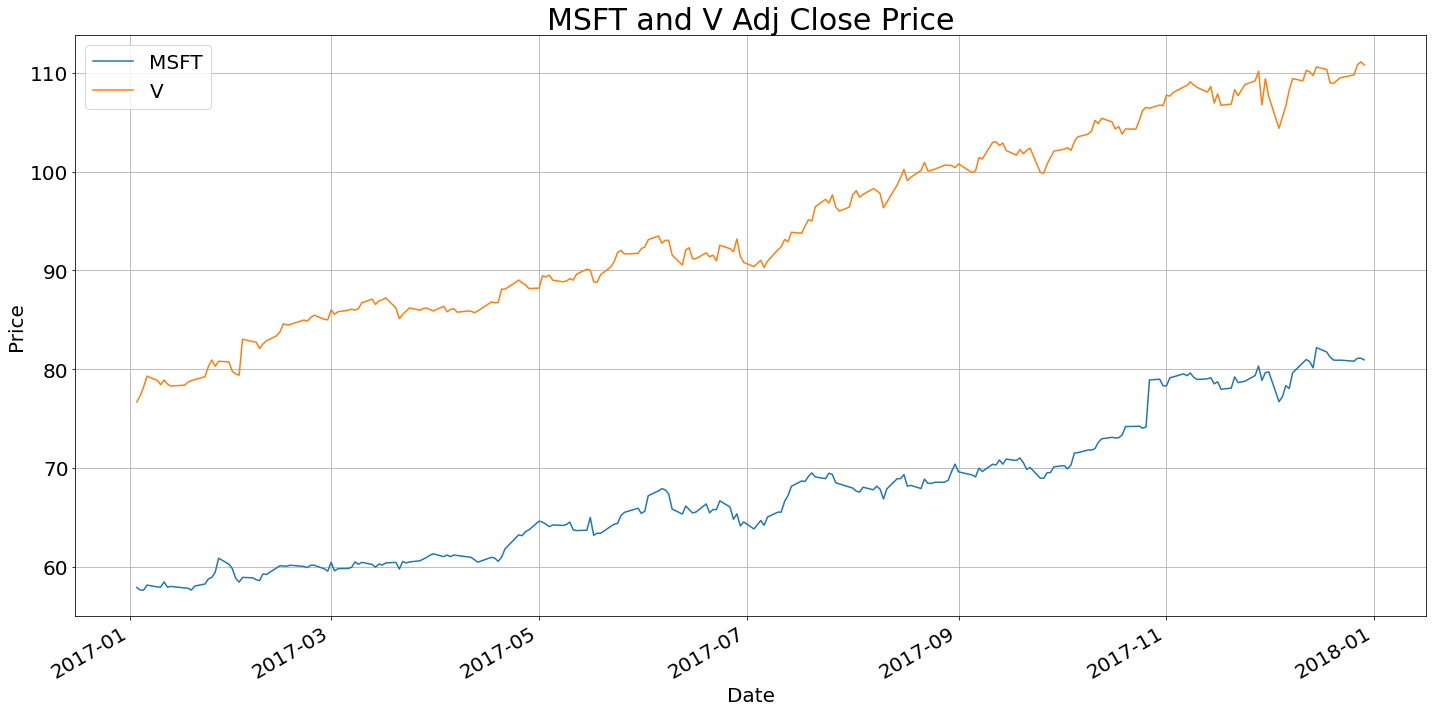

In [7]:
tickers = "MSFT V"
start = "2017-01-01"
end = "2018-01-01"
t_threshold = 0.05

tickers_split = tickers.split()

df = get_data(tickers, start, end)
plot_prices(df, tickers_split)

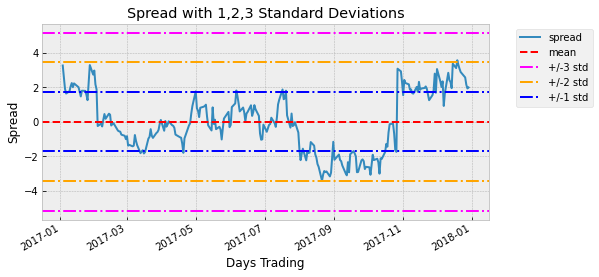

p-value per ADF test on spread is 0.002433626036230714. There is cointegration per ADF test at 0.95 significance level



In [8]:
adf = plot_ADF_spread(df)

if adf[1] <= t_threshold:
    print("p-value per ADF test on spread is " + str(adf[1]) + ". There is cointegration per ADF test at " 
          + str(1-t_threshold) + " significance level\n")
else:
    print("p-value per ADF test on spread is " + str(adf[1]) + ". No cointegration per ADF test at " 
          + str(1-t_threshold) + " significance level\n")

In [9]:
def plot_ADF_sim_spread(sim_spread):    
   
    sim_spread.plot(figsize=(8,4))
    plt.axhline(y=sim_spread.mean(axis=0), color='r', linestyle='--', label="mean")
    plt.axhline(y=sim_spread.std()*3, color='magenta', linestyle='-.', label="+/-3 std")
    plt.axhline(y=sim_spread.std()*-3, color='magenta', linestyle='-.')
    plt.axhline(y=sim_spread.std()*2, color='orange', linestyle='-.', label="+/-2 std")
    plt.axhline(y=sim_spread.std()*-2, color='orange', linestyle='-.')
    plt.axhline(y=sim_spread.std()*1, color='blue', linestyle='-.', label="+/-1 std")
    plt.axhline(y=sim_spread.std()*-1, color='blue', linestyle='-.')
    plt.ylabel("Spread")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()
    
    adf = adfuller(sim_spread,regression='nc', maxlag=1) 
    return adf

In [10]:
# Generate simulated prices using Monte Carlo
MSFT_returns = np.log(1+df["MSFT"].pct_change())
V_returns = np.log(1+df["V"].pct_change())

MSFT_mu, MSFT_sigma = MSFT_returns.mean(), MSFT_returns.std()
V_mu, V_sigma = V_returns.mean(), V_returns.std()

MSFT_initial = df["MSFT"].iloc[-1]
V_initial = df["V"].iloc[-1]

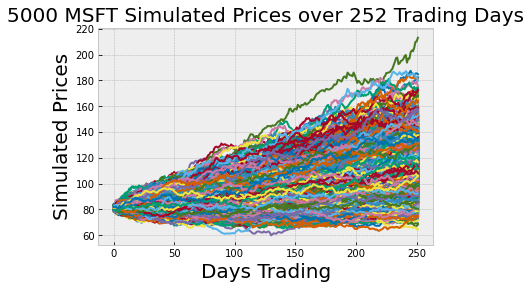

In [11]:
np.random.seed(1)
MSFT_sim_dic = {}


for i in range(5000):
    MSFT_sim = np.random.normal(MSFT_mu, MSFT_sigma, 252)
#     MSFT_sim = np.random.normal(0, MSFT_sigma, 252)
    MSFT_sim = MSFT_initial * (MSFT_sim + 1).cumprod()
    MSFT_sim_dic["MSFT_Sim_"+str(i+1)] = MSFT_sim
    
    plt.title("5000 MSFT Simulated Prices over 252 Trading Days", size=20)
    plt.xlabel("Days Trading", size=20)
    plt.ylabel("Simulated Prices", size=20)
#     plt.rcParams["figure.figsize"] = (10,15)

    plt.plot(MSFT_sim)

MSFT_sim_df = pd.DataFrame.from_dict(MSFT_sim_dic)

(0.0, 330.0)

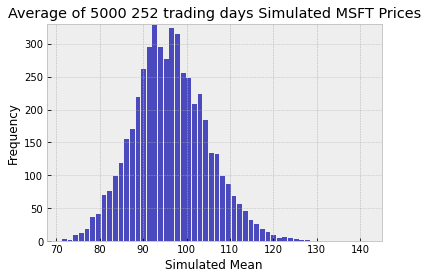

In [12]:
MSFT_sim_mean = MSFT_sim_df.mean(axis=0).to_list()
n, bins, patches = plt.hist(x=MSFT_sim_mean, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Simulated Mean')
plt.ylabel('Frequency')
plt.title('Average of 5000 252 trading days Simulated MSFT Prices')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [13]:
# MSFT_sim_df.head()

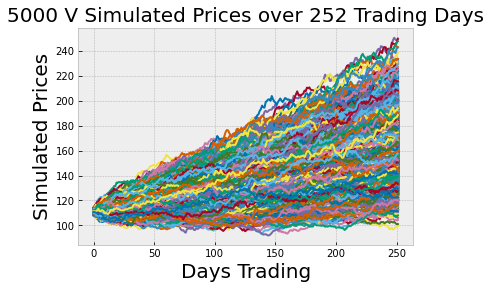

In [14]:
np.random.seed(12)
V_sim_dic = {}

for i in range(5000):
    V_sim = np.random.normal(V_mu, V_sigma, 252)
#     V_sim = np.random.normal(0, V_sigma, 252)
    V_sim = V_initial * (V_sim + 1).cumprod()
    V_sim_dic["V_Sim_"+str(i+1)] = V_sim
    
    plt.title("5000 V Simulated Prices over 252 Trading Days", size=20)
    plt.xlabel("Days Trading", size=20)
    plt.ylabel("Simulated Prices", size=20)
#     plt.rcParams["figure.figsize"] = (10,15)
    
    plt.plot(V_sim)
    
V_sim_df = pd.DataFrame.from_dict(V_sim_dic)

(0.0, 330.0)

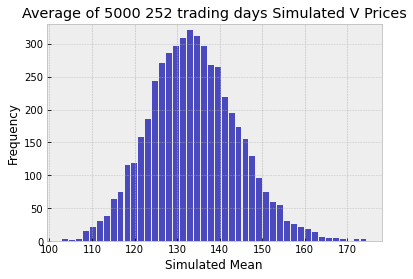

In [15]:
V_sim_mean = V_sim_df.mean(axis=0).to_list()
n, bins, patches = plt.hist(x=V_sim_mean, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Simulated Mean')
plt.ylabel('Frequency')
plt.title('Average of 5000 252 trading days Simulated V Prices')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [16]:
# V_sim_df.head()

In [17]:
coint = []
for i in range(5000):
    sim_prices = pd.DataFrame({'MSFT_sim':MSFT_sim_df["MSFT_Sim_"+str(i+1)], 'V_sim':V_sim_df["V_Sim_"+str(i+1)]})
    adf = ADF_test(sim_prices)

    if adf[1] <= t_threshold:
        coint.append("T")
    else:
        coint.append("F")
        
print("The number of cointegrated simulated prices:", coint.count('T'))

coint_index = [index for index, element in enumerate(coint) if element == 'T']


The number of cointegrated simulated prices: 1466


##### Trading Strategy - Single Observation#####

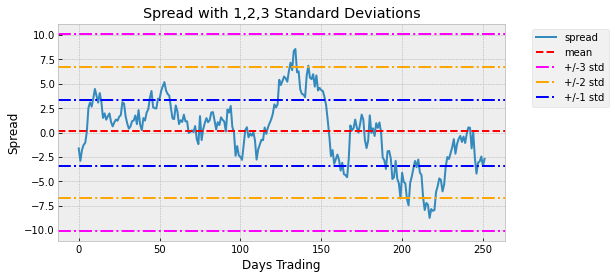

p-value per ADF test on spread is 0.011034110040964946. There is cointegration per ADF test at 0.95 significance level



In [18]:
# Visualize a random spread coresponds to a cointegrated pair
viz_coint = pd.DataFrame({'MSFT_sim':MSFT_sim_df.iloc[:,coint_index[8]], 'V_sim':V_sim_df.iloc[:,coint_index[8]]})
v = plot_ADF_spread(viz_coint)

if v[1] <= t_threshold:
    print("p-value per ADF test on spread is " + str(v[1]) + ". There is cointegration per ADF test at " 
          + str(1-t_threshold) + " significance level\n")
else:
    print("p-value per ADF test on spread is " + str(v[1]) + ". No cointegration per ADF test at " 
          + str(1-t_threshold) + " significance level\n")

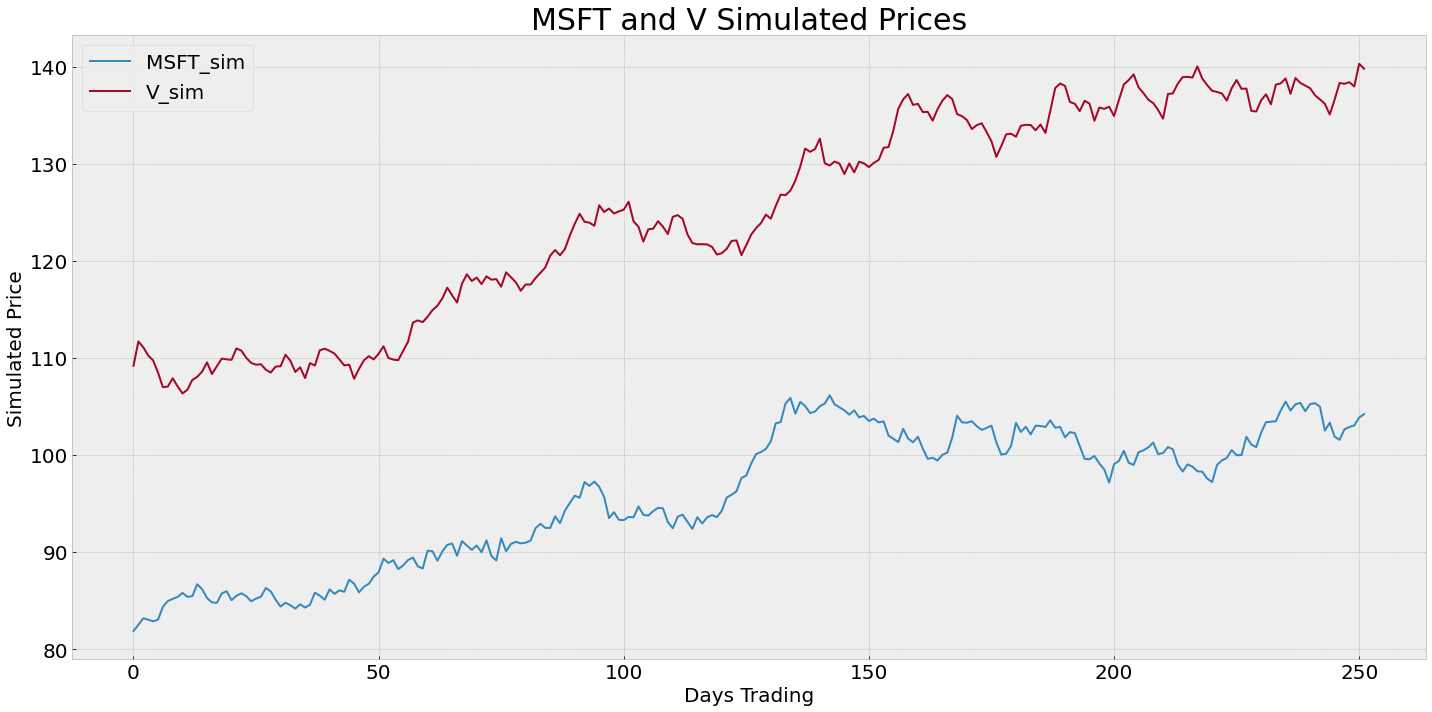

In [19]:
# Plot simulated prices 
def plot_sim_prices(df, tickers_split):
    ax = df.iloc[:,0:2].plot(fontsize=20,figsize=(20, 10))
    ax.set_title(tickers_split[0] +' and ' + tickers_split[1] + ' Simulated Prices',fontsize= 30)
    ax.set_xlabel("Days Trading", fontsize=20)
    ax.set_ylabel("Simulated Price", fontsize=20)
    plt.legend(loc='upper left', fontsize=20)
    plt.tight_layout()
    plt.style.use('bmh')
    plt.grid(True)
    
    return plt.show()

plot_sim_prices(viz_coint, tickers_split)

In [20]:
sim_spread_mean = viz_coint['spread'].mean()
sim_spread_std1 = viz_coint['spread'].std() 
# sim_spread_std2 = viz_coint['spread'].std() * 2
# sim_spread_std3 = viz_coint['spread'].std() * 3

sim_spread_std_1 = -viz_coint['spread'].std() 
# sim_spread_std_2 = -viz_coint['spread'].std() * 2
# sim_spread_std_3 = -viz_coint['spread'].std() * 3

In [21]:
# Create flags of buy/ sell when spread crosses the 1std threshold

for i in range(1, viz_coint.shape[0]):
    a = viz_coint.at[i-1, 'spread']
    b = viz_coint.at[i, 'spread']
    if b >= sim_spread_std1 and a < sim_spread_std1:
        viz_coint.at[i, '(1) buy V-sell MSFT'] = 'T'
    else:
        viz_coint.at[i, '(1) buy V-sell MSFT'] = 'NaN'
        
for i in range(1, viz_coint.shape[0]):
    a = viz_coint.at[i-1, 'spread']
    b = viz_coint.at[i, 'spread']
    if b <= sim_spread_std_1 and a > sim_spread_std_1:
        viz_coint.at[i, '(-1) buy MSFT-sell V'] = 'T'
    else:
        viz_coint.at[i, '(-1) buy MSFT-sell V'] = 'NaN'   
    
for i in range(1, viz_coint.shape[0]):
    a = viz_coint.at[i-1, 'spread']
    b = viz_coint.at[i, 'spread']
    
    if (a < 0 and b > 0) or (a > 0 and b < 0):
        viz_coint.at[i, 'terminate trade'] = 'T'

The strategy is that only the first time the spread crosses the threshold (e.g. +/-1std; +/-2std; +/- 3std) a trade is initiated. 

In [22]:
# address consecutive "T" in "terminate trade" column
l = viz_coint.index[viz_coint['terminate trade'] == "T"].tolist()
grplist = [list(group) for group in mit.consecutive_groups(l)]
final_list = []
for i in grplist:
    final_list.append(i[0])
viz_coint['terminate trade'] = 'NaN'
viz_coint.loc[final_list,'terminate trade'] = 'T'

In [23]:
viz_coint['strategy'] = np.where(viz_coint['(1) buy V-sell MSFT'] == "T", "(1) buy V-sell MSFT", "NaN")
viz_coint.loc[viz_coint['(-1) buy MSFT-sell V'] == 'T', 'strategy'] = "(-1) buy MSFT-sell V"
viz_coint.loc[viz_coint['terminate trade'] == 'T', 'strategy'] = "terminate trade"
viz_coint = viz_coint[viz_coint['strategy'] != 'NaN'].reset_index(drop=True)

In [24]:
# remove consecutive rows based on consecutine "terminate trade" in "strategy" column
l = viz_coint.index[viz_coint['strategy'] == 'terminate trade'].tolist()
grplist = [list(group) for group in mit.consecutive_groups(l)]
final_list = []
for i in grplist:
    if len(i) > 1:
        final_list.append(i[1:])
final_list = [item for sublist in final_list for item in sublist]
viz_coint = viz_coint.drop(final_list)
viz_coint = viz_coint.reset_index(drop=True)

In [25]:
# remove consecutive rows based on consecutine initiate trade in "strategy" column
l = viz_coint.index[viz_coint['strategy'] == '(-1) buy MSFT-sell V'].tolist()
grplist = [list(group) for group in mit.consecutive_groups(l)]
final_list = []
for i in grplist:
    if len(i) > 1:
        final_list.append(i[1:])
final_list = [item for sublist in final_list for item in sublist]
viz_coint = viz_coint.drop(final_list)
############################################################################
l = viz_coint.index[viz_coint['strategy'] == '(1) buy V-sell MSFT'].tolist()
grplist = [list(group) for group in mit.consecutive_groups(l)]
final_list = []
for i in grplist:
    if len(i) > 1:
        final_list.append(i[1:])
final_list = [item for sublist in final_list for item in sublist]
viz_coint = viz_coint.drop(final_list)

viz_coint = viz_coint.reset_index(drop=True)

In [26]:
viz_coint[0:50]

,MSFT_sim,V_sim,spread,(1) buy V-sell MSFT,(-1) buy MSFT-sell V,terminate trade,strategy
0,83.048367,108.507783,0.067963,NaN,NaN,T,terminate trade
1,85.392479,107.080567,3.503527,T,NaN,NaN,(1) buy V-sell MSFT
2,90.683828,118.625671,-0.034146,NaN,NaN,T,terminate trade
3,97.642120,120.596065,5.417304,T,NaN,NaN,(1) buy V-sell MSFT
4,101.672774,133.464103,-0.392764,NaN,NaN,T,terminate trade
5,99.612277,135.355848,-3.899957,NaN,T,NaN,(-1) buy MSFT-sell V
6,104.064786,135.115980,0.735989,NaN,NaN,T,terminate trade
7,101.822350,138.033423,-3.737537,NaN,T,NaN,(-1) buy MSFT-sell V
8,105.348768,137.062556,0.531344,NaN,NaN,T,terminate trade
9,101.572747,138.325853,-4.210773,NaN,T,NaN,(-1) buy MSFT-sell V


In [27]:
rtrn = 0
for i in range(0, viz_coint.shape[0]-1):
    strg = viz_coint.at[i, 'strategy']
    msft = viz_coint.at[i, 'MSFT_sim']
    v = viz_coint.at[i, 'V_sim']
    ter_msft = viz_coint.at[i+1, 'MSFT_sim']
    ter_v = viz_coint.at[i+1, 'V_sim']
    if strg == "(-1) buy MSFT-sell V":
        long = ter_msft - msft
        short = v - ter_v
        total = long + short
        rtrn += total
    elif strg == "(1) buy V-sell MSFT":
        long = ter_v - v
        short = msft - ter_msft
        total = long + short
        rtrn += total
        
rtrn
    

24.28080130826433

##### Trading Strategy 1std - Aggregated return across all simulated prices #####

In [28]:
# Function to generate the 'spread' column 
def spread(df):
    X = df.iloc[:,0]
    Y = df.iloc[:,1]
    model = sm.OLS(X, Y)
    model = model.fit()
    df['spread'] = X - model.params[0] * Y
    return df

In [29]:
std1_rtrn = 0
std_rtrn_idv = []

for sim in coint_index:
    s = pd.DataFrame({'MSFT_sim':MSFT_sim_df.iloc[:,sim], 'V_sim':V_sim_df.iloc[:,sim]})
    s = spread(s)
    sim_spread_std1 = s['spread'].std() 
    sim_spread_std_1 = -s['spread'].std() 
    
    # Create flags of buy/ sell when spread crosses the 1std threshold    
    for i in range(1, s.shape[0]):
        a = s.at[i-1, 'spread']
        b = s.at[i, 'spread']
    if b >= sim_spread_std1 and a < sim_spread_std1:
        s.at[i, '(1) buy V-sell MSFT'] = 'T'
    else:
        s.at[i, '(1) buy V-sell MSFT'] = 'NaN'
        
    for i in range(1, s.shape[0]):
        a = s.at[i-1, 'spread']
        b = s.at[i, 'spread']
        if b <= sim_spread_std_1 and a > sim_spread_std_1:
            s.at[i, '(-1) buy MSFT-sell V'] = 'T'
        else:
            s.at[i, '(-1) buy MSFT-sell V'] = 'NaN'   

    for i in range(1, s.shape[0]):
        a = s.at[i-1, 'spread']
        b = s.at[i, 'spread']

        if (a < 0 and b > 0) or (a > 0 and b < 0):
            s.at[i, 'terminate trade'] = 'T'
            
    # Address consecutive "T" in "terminate trade" column
    l = s.index[s['terminate trade'] == "T"].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        final_list.append(i[0])
    s['terminate trade'] = 'NaN'
    s.loc[final_list,'terminate trade'] = 'T'

    s['strategy'] = np.where(s['(1) buy V-sell MSFT'] == "T", "(1) buy V-sell MSFT", "NaN")
    s.loc[s['(-1) buy MSFT-sell V'] == 'T', 'strategy'] = "(-1) buy MSFT-sell V"
    s.loc[s['terminate trade'] == 'T', 'strategy'] = "terminate trade"
    s = s[s['strategy'] != 'NaN'].reset_index(drop=True)
    
    # Remove consecutive rows based on consecutine "terminate trade" in "strategy" column
    l = s.index[s['strategy'] == 'terminate trade'].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        if len(i) > 1:
            final_list.append(i[1:])
    final_list = [item for sublist in final_list for item in sublist]
    s = s.drop(final_list)
    s = s.reset_index(drop=True)
    
    # Remove consecutive rows based on consecutine initiate trade in "strategy" column
    l = s.index[s['strategy'] == '(-1) buy MSFT-sell V'].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        if len(i) > 1:
            final_list.append(i[1:])
    final_list = [item for sublist in final_list for item in sublist]
    s = s.drop(final_list)
    ############################################################################
    l = s.index[s['strategy'] == '(1) buy V-sell MSFT'].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        if len(i) > 1:
            final_list.append(i[1:])
    final_list = [item for sublist in final_list for item in sublist]
    s = s.drop(final_list)

    s = s.reset_index(drop=True)

    # Calculate return
    rtrn = 0
    for i in range(0, s.shape[0]-1):
        strg = s.at[i, 'strategy']
        msft = s.at[i, 'MSFT_sim']
        v = s.at[i, 'V_sim']
        ter_msft = s.at[i+1, 'MSFT_sim']
        ter_v = s.at[i+1, 'V_sim']
        if strg == "(-1) buy MSFT-sell V":
            long = ter_msft - msft
            short = v - ter_v
            total = long + short
            rtrn += total
        elif strg == "(1) buy V-sell MSFT":
            long = ter_v - v
            short = msft - ter_msft
            total = long + short
            rtrn += total
            
           
    std1_rtrn += rtrn
    std_rtrn_idv.append(rtrn)
    
print("Total aggregated retruns over all simulated prices with threshold of 1 standard deviation is:", std1_rtrn)

Total aggregated retruns over all simulated prices with threshold of 1 standard deviation is: 17072.76082371066


(0.0, 140.0)

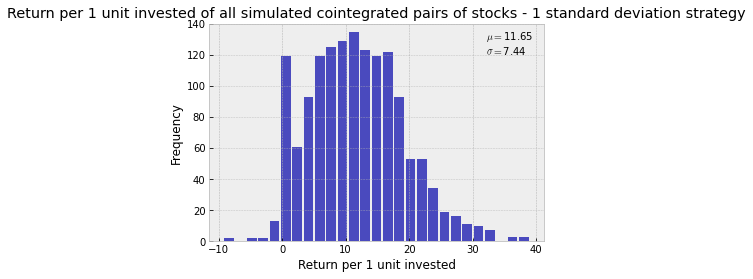

In [30]:
mu1 = round(np.mean(std_rtrn_idv),2)
std1 = round(st.stdev(std_rtrn_idv),2)
n, bins, patches = plt.hist(x=std_rtrn_idv, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Return per 1 unit invested')
plt.ylabel('Frequency')
plt.title('Return per 1 unit invested of all simulated cointegrated pairs of stocks - 1 standard deviation strategy')
plt.text(32, 130, r'$\mu=$'+str(mu1))
plt.text(32, 120, r'$\sigma=$'+str(std1))
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

##### Trading Strategy 2std - Aggregated return across all simulated prices #####

In [31]:
std2_rtrn = 0
std2_rtrn_idv = []

for sim in coint_index:
    s = pd.DataFrame({'MSFT_sim':MSFT_sim_df.iloc[:,sim], 'V_sim':V_sim_df.iloc[:,sim]})
    s = spread(s)
    sim_spread_std2 = s['spread'].std() * 2
    sim_spread_std_2 = -s['spread'].std() * 2
    
    # Create flags of buy/ sell when spread crosses the 1std threshold    
    for i in range(1, s.shape[0]):
        a = s.at[i-1, 'spread']
        b = s.at[i, 'spread']
    if b >= sim_spread_std2 and a < sim_spread_std2:
        s.at[i, '(2) buy V-sell MSFT'] = 'T'
    else:
        s.at[i, '(2) buy V-sell MSFT'] = 'NaN'
        
    for i in range(1, s.shape[0]):
        a = s.at[i-1, 'spread']
        b = s.at[i, 'spread']
        if b <= sim_spread_std_2 and a > sim_spread_std_2:
            s.at[i, '(-2) buy MSFT-sell V'] = 'T'
        else:
            s.at[i, '(-2) buy MSFT-sell V'] = 'NaN'   

    for i in range(1, s.shape[0]):
        a = s.at[i-1, 'spread']
        b = s.at[i, 'spread']

        if (a < 0 and b > 0) or (a > 0 and b < 0):
            s.at[i, 'terminate trade'] = 'T'
            
    # Address consecutive "T" in "terminate trade" column
    l = s.index[s['terminate trade'] == "T"].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        final_list.append(i[0])
    s['terminate trade'] = 'NaN'
    s.loc[final_list,'terminate trade'] = 'T'

    s['strategy'] = np.where(s['(2) buy V-sell MSFT'] == "T", "(2) buy V-sell MSFT", "NaN")
    s.loc[s['(-2) buy MSFT-sell V'] == 'T', 'strategy'] = "(-2) buy MSFT-sell V"
    s.loc[s['terminate trade'] == 'T', 'strategy'] = "terminate trade"
    s = s[s['strategy'] != 'NaN'].reset_index(drop=True)
    
    # Remove consecutive rows based on consecutine "terminate trade" in "strategy" column
    l = s.index[s['strategy'] == 'terminate trade'].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        if len(i) > 1:
            final_list.append(i[1:])
    final_list = [item for sublist in final_list for item in sublist]
    s = s.drop(final_list)
    s = s.reset_index(drop=True)
    
    # Remove consecutive rows based on consecutine initiate trade in "strategy" column
    l = s.index[s['strategy'] == '(-2) buy MSFT-sell V'].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        if len(i) > 1:
            final_list.append(i[1:])
    final_list = [item for sublist in final_list for item in sublist]
    s = s.drop(final_list)
    ############################################################################
    l = s.index[s['strategy'] == '(2) buy V-sell MSFT'].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        if len(i) > 1:
            final_list.append(i[1:])
    final_list = [item for sublist in final_list for item in sublist]
    s = s.drop(final_list)

    s = s.reset_index(drop=True)

    # Calculate return
    rtrn = 0
    for i in range(0, s.shape[0]-1):
        strg = s.at[i, 'strategy']
        msft = s.at[i, 'MSFT_sim']
        v = s.at[i, 'V_sim']
        ter_msft = s.at[i+1, 'MSFT_sim']
        ter_v = s.at[i+1, 'V_sim']
        if strg == "(-2) buy MSFT-sell V":
            long = ter_msft - msft
            short = v - ter_v
            total = long + short
            rtrn += total
        elif strg == "(2) buy V-sell MSFT":
            long = ter_v - v
            short = msft - ter_msft
            total = long + short
            rtrn += total
            
           
    std2_rtrn += rtrn
    std2_rtrn_idv.append(rtrn)
    
print("Total aggregated retruns over all simulated prices with threshold of 2 standard deviation is:", std2_rtrn)

Total aggregated retruns over all simulated prices with threshold of 2 standard deviation is: 9790.800660196765


(0.0, 630.0)

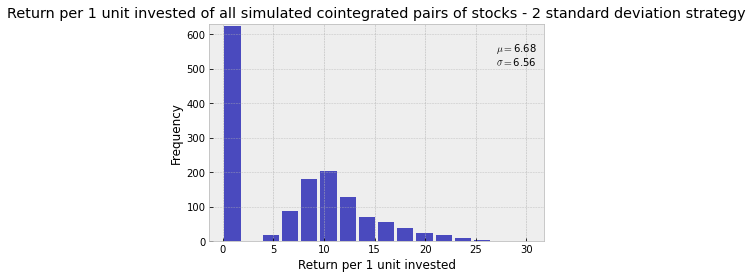

In [32]:
mu2 = round(np.mean(std2_rtrn_idv),2)
std2 = round(st.stdev(std2_rtrn_idv),2)
n, bins, patches = plt.hist(x=std2_rtrn_idv, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Return per 1 unit invested')
plt.ylabel('Frequency')
plt.title('Return per 1 unit invested of all simulated cointegrated pairs of stocks - 2 standard deviation strategy')
plt.text(27, 550, r'$\mu=$'+str(mu2))
plt.text(27, 510, r'$\sigma=$'+str(std2))
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

##### Trading Strategy 3std - Aggregated return across all simulated prices #####

In [33]:
std3_rtrn = 0
std3_rtrn_idv = []

for sim in coint_index:
    s = pd.DataFrame({'MSFT_sim':MSFT_sim_df.iloc[:,sim], 'V_sim':V_sim_df.iloc[:,sim]})
    s = spread(s)
    sim_spread_std3 = s['spread'].std() * 3
    sim_spread_std_3 = -s['spread'].std() * 3
    
    # Create flags of buy/ sell when spread crosses the 1std threshold    
    for i in range(1, s.shape[0]):
        a = s.at[i-1, 'spread']
        b = s.at[i, 'spread']
    if b >= sim_spread_std3 and a < sim_spread_std3:
        s.at[i, '(3) buy V-sell MSFT'] = 'T'
    else:
        s.at[i, '(3) buy V-sell MSFT'] = 'NaN'
        
    for i in range(1, s.shape[0]):
        a = s.at[i-1, 'spread']
        b = s.at[i, 'spread']
        if b <= sim_spread_std_3 and a > sim_spread_std_3:
            s.at[i, '(-3) buy MSFT-sell V'] = 'T'
        else:
            s.at[i, '(-3) buy MSFT-sell V'] = 'NaN'   

    for i in range(1, s.shape[0]):
        a = s.at[i-1, 'spread']
        b = s.at[i, 'spread']

        if (a < 0 and b > 0) or (a > 0 and b < 0):
            s.at[i, 'terminate trade'] = 'T'
            
    # Address consecutive "T" in "terminate trade" column
    l = s.index[s['terminate trade'] == "T"].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        final_list.append(i[0])
    s['terminate trade'] = 'NaN'
    s.loc[final_list,'terminate trade'] = 'T'

    s['strategy'] = np.where(s['(3) buy V-sell MSFT'] == "T", "(3) buy V-sell MSFT", "NaN")
    s.loc[s['(-3) buy MSFT-sell V'] == 'T', 'strategy'] = "(-3) buy MSFT-sell V"
    s.loc[s['terminate trade'] == 'T', 'strategy'] = "terminate trade"
    s = s[s['strategy'] != 'NaN'].reset_index(drop=True)
    
    # Remove consecutive rows based on consecutine "terminate trade" in "strategy" column
    l = s.index[s['strategy'] == 'terminate trade'].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        if len(i) > 1:
            final_list.append(i[1:])
    final_list = [item for sublist in final_list for item in sublist]
    s = s.drop(final_list)
    s = s.reset_index(drop=True)
    
    # Remove consecutive rows based on consecutine initiate trade in "strategy" column
    l = s.index[s['strategy'] == '(-3) buy MSFT-sell V'].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        if len(i) > 1:
            final_list.append(i[1:])
    final_list = [item for sublist in final_list for item in sublist]
    s = s.drop(final_list)
    ############################################################################
    l = s.index[s['strategy'] == '(3) buy V-sell MSFT'].tolist()
    grplist = [list(group) for group in mit.consecutive_groups(l)]
    final_list = []
    for i in grplist:
        if len(i) > 1:
            final_list.append(i[1:])
    final_list = [item for sublist in final_list for item in sublist]
    s = s.drop(final_list)

    s = s.reset_index(drop=True)

    # Calculate return
    rtrn = 0
    for i in range(0, s.shape[0]-1):
        strg = s.at[i, 'strategy']
        msft = s.at[i, 'MSFT_sim']
        v = s.at[i, 'V_sim']
        ter_msft = s.at[i+1, 'MSFT_sim']
        ter_v = s.at[i+1, 'V_sim']
        if strg == "(-3) buy MSFT-sell V":
            long = ter_msft - msft
            short = v - ter_v
            total = long + short
            rtrn += total
        elif strg == "(3) buy V-sell MSFT":
            long = ter_v - v
            short = msft - ter_msft
            total = long + short
            rtrn += total
            
           
    std3_rtrn += rtrn
    std3_rtrn_idv.append(rtrn)
    
print("Total aggregated retruns over all simulated prices with threshold of 3 standard deviation is:", std3_rtrn)

Total aggregated retruns over all simulated prices with threshold of 3 standard deviation is: 444.2311061108384


(0.0, 1440.0)

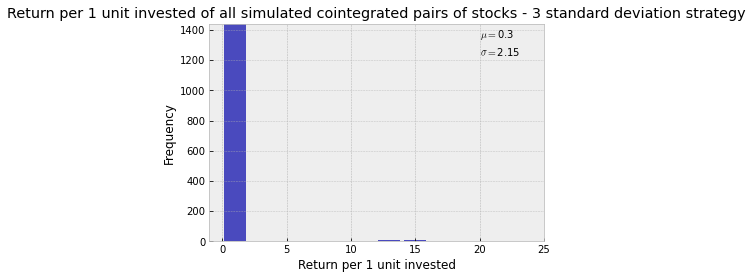

In [34]:
mu3 = round(np.mean(std3_rtrn_idv),2)
std3 = round(st.stdev(std3_rtrn_idv),2)
n, bins, patches = plt.hist(x=std3_rtrn_idv, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Return per 1 unit invested')
plt.ylabel('Frequency')
plt.title('Return per 1 unit invested of all simulated cointegrated pairs of stocks - 3 standard deviation strategy')
plt.text(20, 1350, r'$\mu=$'+str(mu3))
plt.text(20, 1230, r'$\sigma=$'+str(std3))
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)